In [1]:

import warnings

import matplotlib.pyplot as plt
# import MultiTrade
import numpy as np
import pandas as pd
from gym_trading_env.downloader import download

from IPython.display import display


from utils.forecast_utils import build_model_get_data, get_dataset_columns
from utils.utils import build_market_image, preprocess_data

warnings.filterwarnings("ignore")

from neuralforecast.core import NeuralForecast
from neuralforecast.losses.numpy import mae, mse
from neuralforecast.models import NBEATS, NHITS, PatchTST

In [2]:
COIN_PAIRS=['BTC/USDT','ETH/USDT','SOL/USDT','BNB/USDT','XRP/USDT','ADA/USDT',
            'ETH/BTC','SOL/ETH','BNB/ETH','XRP/ETH',"ADA/ETH",
            'SOL/BTC','SOL/BNB',
            'XRP/BTC','XRP/BNB',
            'ADA/BTC','ADA/BNB',
            ]
target_pair='ETHUSDT'
time_frame="1h"

In [23]:
data=build_market_image(target_pair='ETH/USDT',indicators=[],time_frame='1h',axis=0)
data
data=data.groupby('symbol').apply(lambda x: x[:pd.Timestamp('2024-01-01')])

# # data.to_csv('data/binance-market-1h.csv')

# data=data.groupby('symbol').apply(lambda x: x[:pd.Timestamp('2024-01-01')])

# data=data.reset_index(level=0,drop=True).reset_index()
# data=data[data['symbol']=='ETHUSDT'].copy()
data['symbol'].unique()
id_columns=['symbol']
output_columns,feature_columns,drop_columns=get_dataset_columns(data,id_columns=['symbol'])
len(output_columns)+len(data[id_columns[0]].unique())

['data/binanceus-ADAUSDT-1h.pkl', 'data/binanceus-ETHUSDT-1h.pkl', 'data/binanceus-XRPUSDT-1h.pkl', 'data/binanceus-BNBUSDT-1h.pkl', 'data/binanceus-SOLUSDT-1h.pkl', 'data/binanceus-SOLETH-1h.pkl', 'data/binanceus-ETHBTC-1h.pkl', 'data/binanceus-BTCUSDT-1h.pkl']


0it [00:00, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

9

In [24]:
data

open     high      low    close    volume  \
symbol  date_close                                                          
ADAUSDT 2022-01-01 10:00:00  1.32722  1.33190  1.31975  1.32726   14602.3   
        2022-01-01 11:00:00  1.32840  1.33253  1.30971  1.31740   46730.7   
        2022-01-01 12:00:00  1.31783  1.32531  1.31637  1.32047   17277.5   
        2022-01-01 13:00:00  1.31874  1.33270  1.31874  1.33140   69390.0   
        2022-01-01 14:00:00  1.33140  1.33969  1.32644  1.32844  122469.0   
...                              ...      ...      ...      ...       ...   
XRPUSDT 2023-12-31 20:00:00  0.62170  0.62170  0.62090  0.62090    2393.0   
        2023-12-31 21:00:00  0.62080  0.62080  0.61860  0.61860   11542.0   
        2023-12-31 22:00:00  0.61930  0.62100  0.61880  0.61950    3658.0   
        2023-12-31 23:00:00  0.61920  0.61950  0.61000  0.61210   54436.0   
        2024-01-01 00:00:00  0.61210  0.61480  0.61160  0.61450    5973.0   

                                   y  feature_hour_of_day  \
symbol  date_close                                          
ADAUSDT 2022-01-01 10:00:00  1.32726            -0.065217   
        2022-01-01 11:00:00  1.31740            -0.021739   
        2022-01-01 12:00:00  1.32047             0.021739   
        2022-01-01 13:00:00  1.33140             0.065217   
        2022-01-01 14:00:00  1.32844             0.108696   
...                              ...                  ...   
XRPUSDT 2023-12-31 20:00:00  0.62090             0.369565   
        2023-12-31 21:00:00  0.61860             0.413043   
        2023-12-31 22:00:00  0.61950             0.456522   
        2023-12-31 23:00:00  0.61210             0.500000   
        2024-01-01 00:00:00  0.61450            -0.500000   

                             feature_day_of_week  feature_day_of_month  \
symbol  date_close                                                       
ADAUSDT 2022-01-01 10:00:00             0.333333                  -0.5   
        2022-01-01 11:00:00             0.333333                  -0.5   
        2022-01-01 12:00:00             0.333333                  -0.5   
        2022-01-01 13:00:00             0.333333                  -0.5   
        2022-01-01 14:00:00             0.333333                  -0.5   
...                                          ...                   ...   
XRPUSDT 2023-12-31 20:00:00             0.500000                   0.5   
        2023-12-31 21:00:00             0.500000                   0.5   
        2023-12-31 22:00:00             0.500000                   0.5   
        2023-12-31 23:00:00             0.500000                   0.5   
        2024-01-01 00:00:00            -0.500000                  -0.5   

                             feature_day_of_year                  ds  \
symbol  date_close                                                     
ADAUSDT 2022-01-01 10:00:00             -0.50000 2022-01-01 10:00:00   
        2022-01-01 11:00:00             -0.50000 2022-01-01 11:00:00   
        2022-01-01 12:00:00             -0.50000 2022-01-01 12:00:00   
        2022-01-01 13:00:00             -0.50000 2022-01-01 13:00:00   
        2022-01-01 14:00:00             -0.50000 2022-01-01 14:00:00   
...                                          ...                 ...   
XRPUSDT 2023-12-31 20:00:00              0.49726 2023-12-31 20:00:00   
        2023-12-31 21:00:00              0.49726 2023-12-31 21:00:00   
        2023-12-31 22:00:00              0.49726 2023-12-31 22:00:00   
        2023-12-31 23:00:00              0.49726 2023-12-31 23:00:00   
        2024-01-01 00:00:00             -0.50000 2024-01-01 00:00:00   

                             unique_id   symbol  
symbol  date_close                               
ADAUSDT 2022-01-01 10:00:00          3  ADAUSDT  
        2022-01-01 11:00:00          3  ADAUSDT  
        2022-01-01 12:00:00          3  ADAUSDT  
        2022-01-01 13:00:00          3  ADAUSDT  
        2022-01-01 14:00:00         

In [25]:

# data['ds']=data['date_open']
# data=data.drop(['date_open','symbol'],axis=1)
front=['y','ds','unique_id','symbol']
data=data[front+[c for c in data.columns if c not in front]]
data=data[front]
data['symbol'].unique()

array(['ADAUSDT', 'BNBUSDT', 'BTCUSDT', 'ETHBTC', 'ETHUSDT', 'SOLETH',
       'SOLUSDT', 'XRPUSDT'], dtype=object)

In [9]:
data

,open_ADAUSDT,high_ADAUSDT,low_ADAUSDT,close_ADAUSDT,volume_ADAUSDT,y_ADAUSDT,feature_hour_of_day_ADAUSDT,feature_day_of_week_ADAUSDT,feature_day_of_month_ADAUSDT,feature_day_of_year_ADAUSDT,...,high_BTCUSDT,low_BTCUSDT,close_BTCUSDT,volume_BTCUSDT,y_BTCUSDT,feature_hour_of_day_BTCUSDT,feature_day_of_week_BTCUSDT,feature_day_of_month_BTCUSDT,feature_day_of_year_BTCUSDT,ds_BTCUSDT
date_close,,,,,,,,,,,,,,,,,,,,,
2022-01-01 10:00:00,1.32722,1.33190,1.31975,1.32726,14602.3,1.32726,-0.065217,0.333333,-0.5,-0.500000,...,47142.39,46950.47,47117.50,1.315933,47117.50,-0.065217,0.333333,-0.5,-0.500000,2022-01-01 10:00:00
2022-01-01 11:00:00,1.32840,1.33253,1.30971,1.31740,46730.7,1.31740,-0.021739,0.333333,-0.5,-0.500000,...,47280.92,46728.66,46960.60,5.594814,46960.60,-0.021739,0.333333,-0.5,-0.500000,2022-01-01 11:00:00
2022-01-01 12:00:00,1.31783,1.32531,1.31637,1.32047,17277.5,1.32047,0.021739,0.333333,-0.5,-0.500000,...,46998.69,46775.69,46789.92,1.147573,46789.92,0.021739,0.333333,-0.5,-0.500000,2022-01-01 12:00:00
2022-01-01 13:00:00,1.31874,1.33270,1.31874,1.33140,69390.0,1.33140,0.065217,0.333333,-0.5,-0.500000,...,47137.97,46776.14,47090.06,0.895922,47090.06,0.065217,0.333333,-0.5,-0.500000,2022-01-01 13:00:00
2022-01-01 14:00:00,1.33140,1.33969,1.32644,1.32844,122469.0,1.32844,0.108696,0.333333,-0.5,-0.500000,...,47192.97,46978.80,47017.68,2.088049,47017.68,0.108696,0.333333,-0.5,-0.500000,2022-01-01 14:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-28 15:00:00,0.45460,0.45740,0.45290,0.45510,5387.7,0.45510,0.152174,-0.333333,0.4,-0.094521,...,68272.44,67575.20,68013.04,2.782710,68013.04,0.152174,-0.333333,0.4,-0.094521,2024-05-28 15:00:00
2024-05-28 16:00:00,0.45440,0.45890,0.45400,0.45890,4204.3,0.45890,0.195652,-0.333333,0.4,-0.094521,...,68454.47,67801.32,68390.00,1.800320,68390.00,0.195652,-0.333333,0.4,-0.094521,2024-05-28 16:00:00
2024-05-28 17:00:00,0.45730,0.45910,0.45540,0.45670,3493.3,0.45670,0.239130,-0.333333,0.4,-0.094521,...,68464.93,67734.03,67784.37,0.885390,67784.37,0.239130,-0.333333,0.4,-0.094521,2024-05-28 17:00:00


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


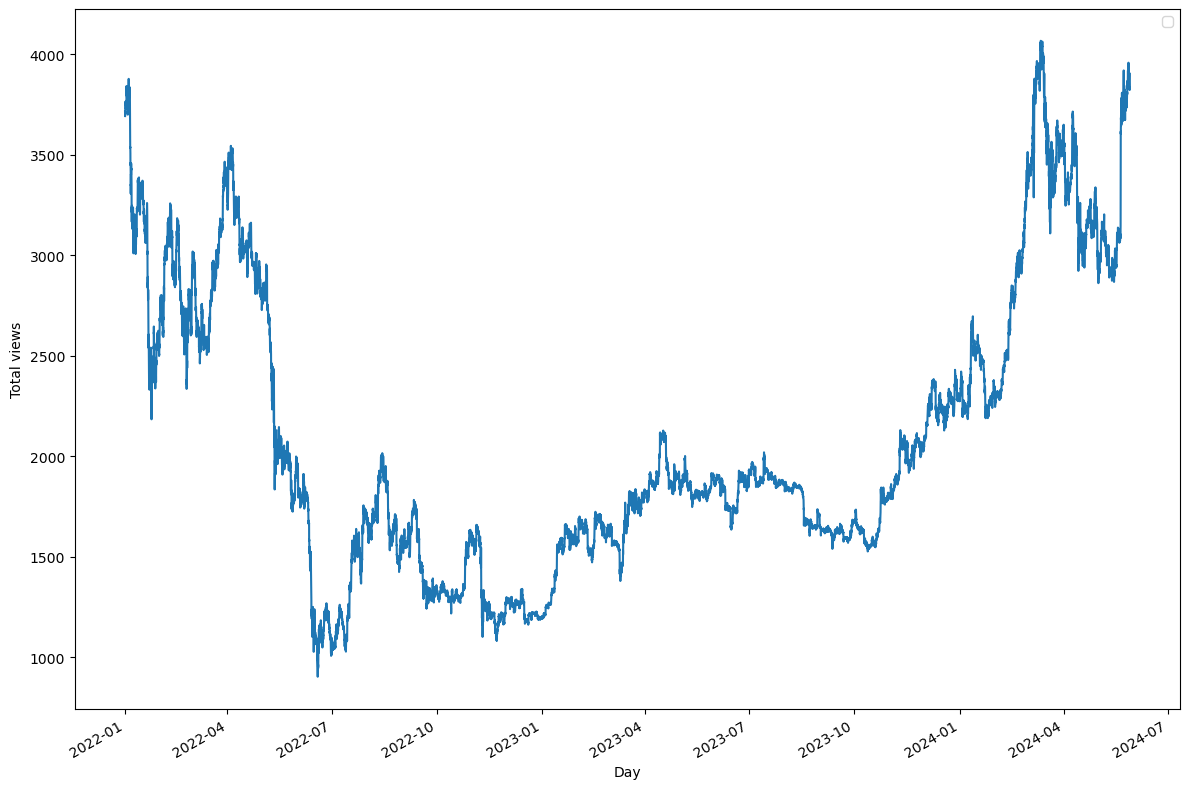

In [10]:


fig, ax = plt.subplots(figsize=(12,8))

ax.plot(data['ds'], data['y'])
# ax.scatter(data['ds'], data['y'], marker='o', color='red', label='New article')
ax.set_xlabel('Day')
ax.set_ylabel('Total views')
ax.legend(loc='best')

fig.autofmt_xdate()


plt.tight_layout()

In [12]:
split=int(len(data)*.7)
print(split)
train = data[:split]
test = data[split:]
# future_exog = test[['unique_id','y']]
test.filter


14752


,open_ADAUSDT,high_ADAUSDT,low_ADAUSDT,close_ADAUSDT,volume_ADAUSDT,y_ADAUSDT,feature_hour_of_day_ADAUSDT,feature_day_of_week_ADAUSDT,feature_day_of_month_ADAUSDT,feature_day_of_year_ADAUSDT,...,high_BTCUSDT,low_BTCUSDT,close_BTCUSDT,volume_BTCUSDT,y_BTCUSDT,feature_hour_of_day_BTCUSDT,feature_day_of_week_BTCUSDT,feature_day_of_month_BTCUSDT,feature_day_of_year_BTCUSDT,ds_BTCUSDT
date_close,,,,,,,,,,,,,,,,,,,,,
2023-09-08 09:00:00,0.2580,0.2580,0.2580,0.2580,1781.9,0.2580,-0.108696,0.166667,-0.266667,0.184932,...,26274.40,26188.91,26205.00,1.93143,26205.00,-0.108696,0.166667,-0.266667,0.184932,2023-09-08 09:00:00
2023-09-08 10:00:00,0.2574,0.2574,0.2564,0.2564,5711.0,0.2564,-0.065217,0.166667,-0.266667,0.184932,...,26209.97,26036.90,26037.10,3.69774,26037.10,-0.065217,0.166667,-0.266667,0.184932,2023-09-08 10:00:00
2023-09-08 11:00:00,0.2560,0.2560,0.2533,0.2535,30062.7,0.2535,-0.021739,0.166667,-0.266667,0.184932,...,26036.76,25689.90,25831.66,22.16680,25831.66,-0.021739,0.166667,-0.266667,0.184932,2023-09-08 11:00:00
2023-09-08 12:00:00,0.2539,0.2542,0.2536,0.2536,984.6,0.2536,0.021739,0.166667,-0.266667,0.184932,...,25893.61,25815.53,25840.20,4.22163,25840.20,0.021739,0.166667,-0.266667,0.184932,2023-09-08 12:00:00
2023-09-08 13:00:00,0.2536,0.2548,0.2536,0.2541,19693.2,0.2541,0.065217,0.166667,-0.266667,0.184932,...,25903.03,25797.49,25850.20,3.96299,25850.20,0.065217,0.166667,-0.266667,0.184932,2023-09-08 13:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-28 15:00:00,0.4546,0.4574,0.4529,0.4551,5387.7,0.4551,0.152174,-0.333333,0.400000,-0.094521,...,68272.44,67575.20,68013.04,2.78271,68013.04,0.152174,-0.333333,0.400000,-0.094521,2024-05-28 15:00:00
2024-05-28 16:00:00,0.4544,0.4589,0.4540,0.4589,4204.3,0.4589,0.195652,-0.333333,0.400000,-0.094521,...,68454.47,67801.32,68390.00,1.80032,68390.00,0.195652,-0.333333,0.400000,-0.094521,2024-05-28 16:00:00
2024-05-28 17:00:00,0.4573,0.4591,0.4554,0.4567,3493.3,0.4567,0.239130,-0.333333,0.400000,-0.094521,...,68464.93,67734.03,67784.37,0.88539,67784.37,0.239130,-0.333333,0.400000,-0.094521,2024-05-28 17:00:00


In [ ]:
horizon = 7
context_length=5*horizon
max_steps=2000
models = [NHITS(h=horizon,
               input_size=context_length,
               max_steps=20000,
               enable_progress_bar=False
               ),
         NBEATS(h=horizon,
               input_size=context_length,
               max_steps=20000,
               enable_progress_bar=False
               
               ),
         PatchTST(h=horizon,
                 input_size=context_length,
                 max_steps=20000,
               enable_progress_bar=False
                 
                 )
                 ]
nf = NeuralForecast(models=models,

                     freq='1h')

In [ ]:
nf.fit(train,
        val_size=horizon,
        time_col='ds',                    
        target_col='y',
        
        )


In [ ]:
nf.save('/Users/sebastiancoombs/Documents/Git/MultiTrader/MultiTrade',overwrite=True)

In [ ]:

Y_pred = nf.predict().reset_index()
preds_df=Y_pred
preds_df['mean_pred']=preds_df[['NHITS', 'NBEATS','PatchTST']].mean(1)
preds_df= preds_df.merge(test, how='left', on=['unique_id', 'ds'])
preds_df=pd.concat([train.tail(48),preds_df])
preds_df

In [ ]:
def plot_preds(plotting_df,col='mean_pred',cut=False):
    plotting_df=plotting_df.reset_index()
    plt.figure(figsize=(10, 5))
    plt.plot(plotting_df['ds'], plotting_df['y'], label='True')

    plot_col='cutoff' if (('cutoff' in plotting_df.columns) and (cut)) else 'ds'
    plt.plot(plotting_df[plot_col], plotting_df[col], label='Forecast')
    # plt.axvline(preds_df['ds'].iloc[horizon], color='black', linestyle='--', label='Train-Test Split')
    plt.xlabel('Timestamp [t]')
    plt.ylabel('Eth_price')
    plt.grid()
    plt.legend()
    


In [ ]:
model=nf.models[0]
model.max_steps
test_df=test.reset_index(drop=True)
model.max_steps,model.step_size,

In [ ]:
plot_size=500
context_length=5*horizon
end=np.random.randint(0,len(test)-plot_size)
end=end if end>0 else 1
start=end-context_length if (end-context_length)>0 else 0
pred_ids=test_df.index[start:end]
df=test_df.loc[pred_ids]
df=df[['ds','unique_id','y']]
df_plot=test_df.iloc[start:end+horizon].copy().reset_index(drop=True)

nf.dataset, nf.uids, nf.last_dates, nf.ds=nf._prepare_fit(df,
                static_df=None, 
                sort_df=None,
                predict_only=False,
                id_col='unique_id', 
                time_col='ds', 
                target_col='y')


preds_array=np.array([model.predict(nf.dataset) for model in nf.models]).squeeze().mean(0)

# preds_array
df_plot['mean_pred']=np.nan
n_values=int(-preds_array.shape[0])
ids=df_plot.index[n_values:]
df_plot.loc[ids,'mean_pred']=[c for c in preds_array]

plot_preds(df_plot)
# df

In [ ]:
nf.dataset, nf.uids, nf.last_dates, nf.ds=nf._prepare_fit(test_df,
                static_df=None, 
                sort_df=None,
                predict_only=False,
                id_col='unique_id', 
                time_col='ds', 
                target_col='y')

In [ ]:
from itertools import Counter

In [ ]:
all_predictions=nf.predict_insample()


In [ ]:
all_predictions['ds']

In [ ]:

forecasts_series=all_predictions.groupby('cutoff').apply(lambda x: x.select_dtypes(np.number).values.flatten())
forecasts_array=[c for c in forecasts_series]

new_df=test_df[test_df['ds'].isin([c for c in forecasts_series.index])]
print(len(test_df),len(forecasts_array),len(new_df))

In [ ]:
for model in nf.models:
    model.enable_progress_bar=False

In [ ]:
nf.dataset, nf.uids, nf.last_dates, nf.ds=nf._prepare_fit(test_df[['ds','unique_id','y']].tail(horizon),
                static_df=None, 
                sort_df=None ,
                predict_only=True,
                id_col='unique_id', 
                time_col='ds', 
                target_col='y')

In [ ]:
i=0
test_df=test.reset_index(drop=True)
test_df.tail(horizon)


In [ ]:
future=nf.make_future_dataframe()
nf.predict()

In [ ]:
test_pred_df=nf.predict_insample().reset_index()
test_pred_df['mean_pred']=test_pred_df[['NHITS', 'NBEATS','PatchTST']].mean(1)
# test_pred_df['mean_pred']=test_pred_df[['mean_pred']].rolling(horizon).mean(1)
test_pred_df


In [ ]:
plot_preds(test_pred_df)
# test_pred_df


In [ ]:
plot_size=500
start=np.random.randint(0,len(test)-plot_size)
plot_df=test_pred_df.iloc[start:start+plot_size]
plot_df=plot_df.sort_values('ds')
# plot_df=plot_df.groupby('cutoff').mean()
plot_df['mean_pred']=plot_df[['mean_pred']].rolling(horizon).mean()
plot_preds(plot_df,cut=True)

In [ ]:
groups=plot_df.groupby('cutoff')
i=0
max_i=10
for name, df in groups:
    i+=1
    display(df)
    if i>max_i:
        break

In [ ]:
plot_df.groupby('cutoff')['mean_pred'].mean()

In [ ]:
preds_df[['mean_pred','y']].plot()

In [ ]:
preds_df = preds_df.round({
    'NHITS': 4,
    'NBEATS': 4,
    'PatchTST': 4,

})

data = {'N-HiTS': [mae(preds_df['NHITS'], preds_df['y']), mse(preds_df['NHITS'], preds_df['y'])],
       'N-BEATS': [mae(preds_df['NBEATS'], preds_df['y']), mse(preds_df['NBEATS'], preds_df['y'])],
       'PatchTST': [mae(preds_df['PatchTST'], preds_df['y']), mse(preds_df['PatchTST'], preds_df['y'])],
       }

metrics_df = pd.DataFrame(data=data)
metrics_df.index = ['mae', 'mse']

metrics_df.style.highlight_min(color='lightgreen', axis=1)